In [3]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.6 MB/s eta 0:00:0000:01


In [12]:
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=d04f2a758d2eeaea0f0c707b0a0075f5b543409e92ab7870c7530cb76a0a0cee
  Stored in directory: /Users/elibemiss/Library/Caches/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta

[notice] A new release of pip is available: 24.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [18]:
# dependencies
import pandas_ta as ta
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from datetime import datetime
import yfinance as yf

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
today_date = datetime.today().strftime('%Y-%m-%d')

In [3]:
def download_stock_history(ticker, start, end):
    today_date = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(f'{ticker}', start=f'{start}', end=f'{end}')
    return df    

In [24]:
# Practice with log returns
google = download_stock_history('GOOG', start = '2023-01-01', end = '2023-01-08')
google

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2023-01-03  89.830002  91.550003  89.019997  89.699997  89.598038  20738457
2023-01-04  91.010002  91.239998  87.800003  88.709999  88.609169  27046483
2023-01-05  88.070000  88.209999  86.559998  86.769997  86.671371  23136084
2023-01-06  87.360001  88.470001  85.570000  88.160004  88.059799  26612628

In [23]:
# pct change
google_returns = google.Close.pct_change()
google_returns 

# terminal return
google_terminal_return = google.Close[-1]/google.Close[0] - 1
google_terminal_return # -.017168

# cumulative returns (same as above)
google_cum_returns = (1+google_returns).cumprod() - 1
google_cum_returns

# log returns (1+R format)
google_log_returns = np.log(1+google_returns)
google_log_returns

# get cumulative returns using log returns
google_cum_return2 = np.exp(google_log_returns.cumsum()) - 1
google_cum_return2

-0.01716826464354737


Date
2023-01-03         NaN
2023-01-04   -0.011037
2023-01-05   -0.032664
2023-01-06   -0.017168
Name: Close, dtype: float64

### A Basic Trend-Following Strategy
##### - principle: asset price momentum often continues in a certain           direction for a period of time 
##### - trend = direction, momentum = strength of movement
##### - technical indicators: MACD, RSI, MA, Bollinger Bands, volume-based indicators, etc. 
##### - uptrend = long, downtrend = short

#### Moving Averages (MA) - smoothing price data to make trends identifiable
    EMA reacts more quickly to recent price changes (short-term, volatility)
    When a shorter MA crosses above longer MA, bullish signal
    When a shorter MA crosses below a longer MA, bearish signal 

#### Identify i) support and ii) resistance levels (stock bounces between)
    i) support - price level a stock has had difficulty falling below
    ii) resistance - opposite, upper bound of movement
    



In [30]:
apple = download_stock_history('AAPL', start='2020-01-01', end=today_date)

[*********************100%%**********************]  1 of 1 completed


## SIMPLE MOVING AVERAGE:

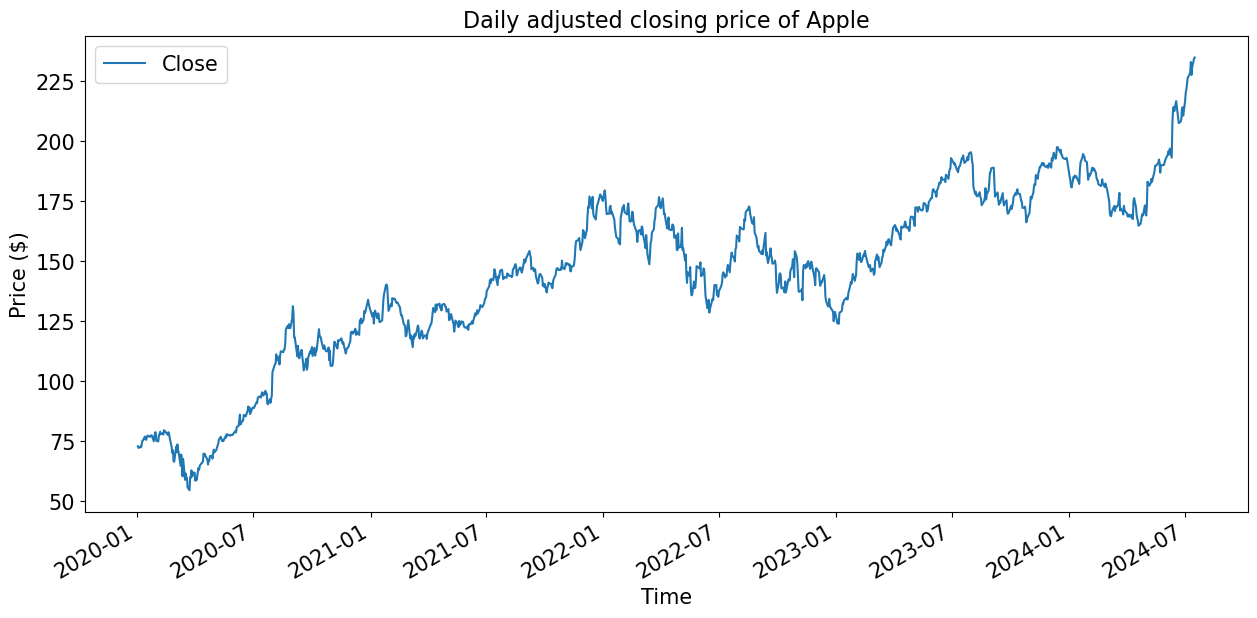

In [31]:
# SMA using AAPL example
plt.figure(figsize=(15,7))
apple['Adj Close'].plot()
# set labels and sizes
plt.title('Daily adjusted closing price of Apple', fontsize=16)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})
# show the plot
plt.show()


## EXPONENTIAL WEIGHTED MOVING AVERAGE (EMA)
#### - more accurate/timely signals, but more prone to produce false signals
#### - α : smoothing factor ranging b/t 0 and 1. determines weight given to most recent price relative to existing EMA. higher means stronger recent price weight
#### - pandas ewm() method

In [36]:
# Create a technical analysis for given stock/period
def create_ta(ticker, start, end):
    #create df
    today_date = datetime.today().strftime('%Y-%m-%d')
    df = yf.download(f'{ticker}', start=f'{start}', end=f'{end}')
    
    #build SMAs
    windows = [3, 20, 50, 100]
    for window in windows:
        df[f'SMA-{window}'] = df['Adj Close'].rolling(window).mean().shift(1)
                                 
    #build EMAs
    spans = [12, 26]
    for span in spans:
        df[f'EWM_{span}'] = df['Adj Close'].ewm(span=span, adjust=False).mean()
    
    #RSI
    df.ta.rsi(append=True)
    #MACD
    #df.ta.macd(append=True)
    
    
    return df

apple = create_ta('AAPL', start='2020-01-01', end=today_date)

[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'Price')

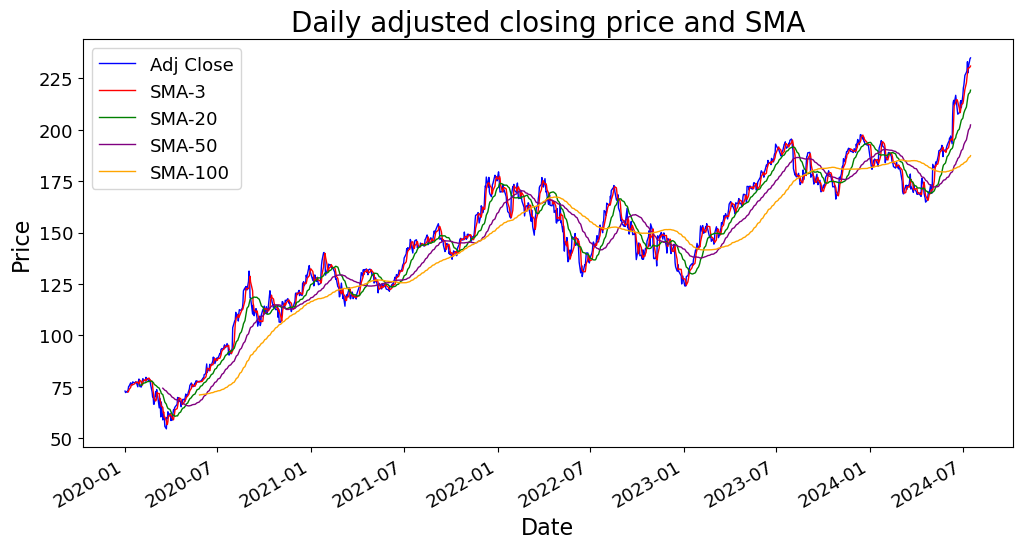

In [62]:
# colors for the plot
colnames = ['Adj Close', 'SMA-3', 'SMA-20', 'SMA-50', 'SMA-100']
apple2 = apple[colnames].copy()

colors = ['blue', 'red', 'green', 'purple', 'orange']
# plot for price and SMA
apple2.plot(color=colors, linewidth=1, figsize=(12,6))
# modify tick size
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(labels = colnames, fontsize = 13)
#title and labels
plt.title('Daily adjusted closing price and SMA', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)

Text(0, 0.5, 'Price')

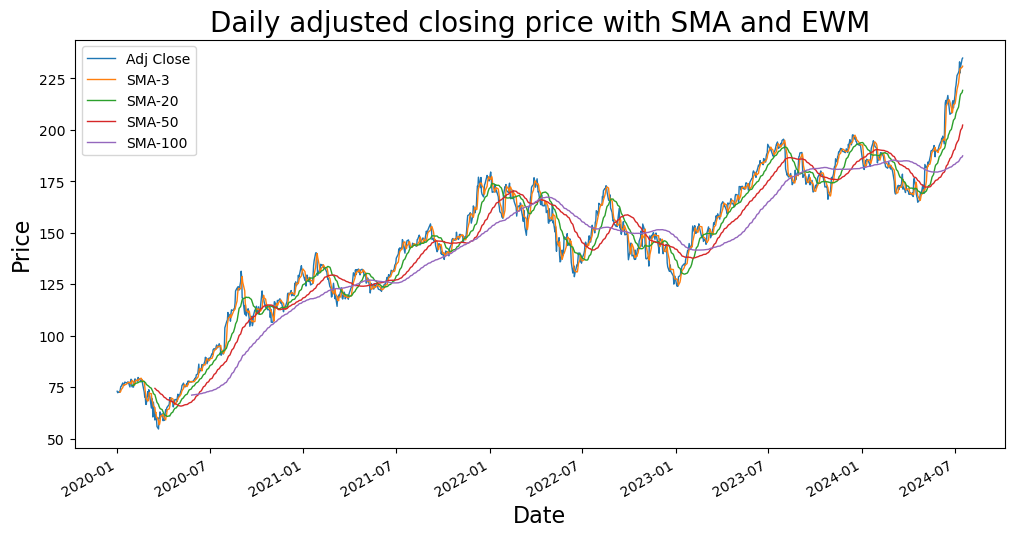

In [63]:
#plot
apple2.plot(linewidth=1, figsize=(12,6))
plt.title('Daily adjusted closing price with SMA and EWM', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)


## TREND FOLLOWING STRATEGY:
### - Two moving averages: one short-term, one long-term
### - When the short-term MA crosses above the long-term MA, BUY signal, long
### - When the short-term MA crosses below the long-term MA, SELL signal, short

In [39]:
apple.head()

Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.960464  135647456   
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.251144  146535512   
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.826866  118578576   
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.484344  104831252   
2020-01-08  74.290001  76.109978  74.289001  75.797501  73.650345  132363784   

                SMA-3  SMA-20  SMA-50  SMA-100     EWM_12     EWM_26  RSI_14  
Date                                                                          
2020-01-02        NaN     NaN     NaN      NaN  72.960464  72.960464     NaN  
2020-01-03        NaN     NaN     NaN      NaN  72.851338  72.907922     NaN  
2020-01-06        NaN     NaN     NaN      NaN  72.847573  72.901918     NaN  
2020-01-07  72.679492     NaN     NaN      NaN  72.791692  72.870987     NaN  
2020-01-08  72.520785     NaN     NaN      NaN  72.923792  72.928717     NaN

In [40]:
#identify signals and create action
def create_trade_signal(df, short_signal, long_signal):
    
    df2 = df.copy()
    #identify buy signal
    df2['signal'] = np.where(df2[short_signal] > df2[long_signal], 1, 0)
    #identify sell signal 
    df2['signal'] = np.where(df2[short_signal] < df2[long_signal], -1, df2['signal'])
    df2.dropna(inplace=True)
    
    #Buy and hold, trend follow strategies: 
    df2['log_return_bnh'] = np.log(df2['Adj Close']).diff()
    df2['log_return_tfs'] = df2['signal'] * df2['log_return_bnh']
    
    #create action when signal sign switches
    df2['action'] = df2.signal.diff()
    
    return df2

In [57]:
apple_trade = create_trade_signal(apple, 'EWM_12', 'EWM_26')

In [58]:
apple_trade['action'].value_counts() # only a few cases where an action is needed

 0.0    1008
-2.0      16
 2.0      16
Name: action, dtype: int64

### Calculate trend-following strategy -- Four scenarios:
    #### Long an asset, log return > 0, tfs reports positive return = 1*long(St+1/St)
    #### Long an asset, log return < 0, tfs reports negative return = 1*log(St+1/St)
    #### short an asset, log return > 0, tfs reports negative return = -1*log(St+1/St)
    #### short an asset, log return < 0, tfs reports positive return = -1*log(St+1/St)

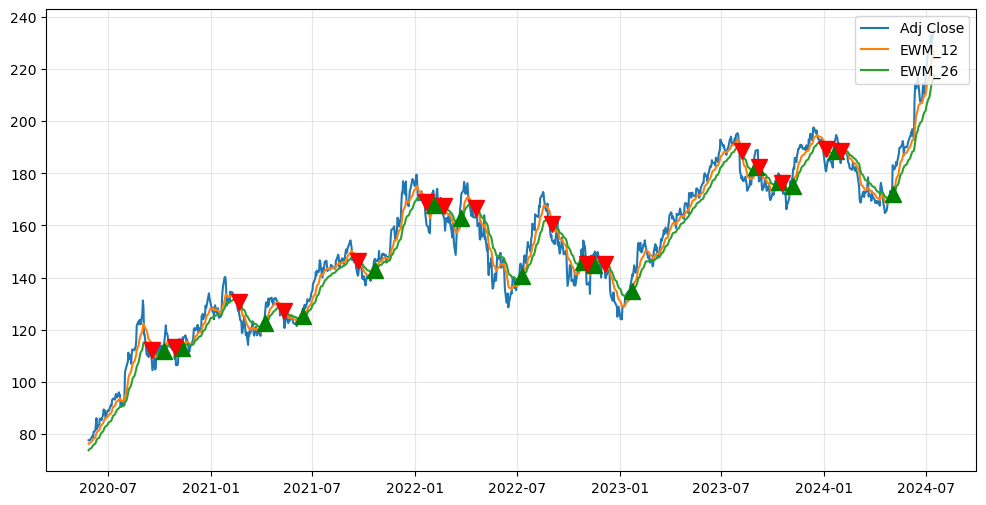

In [59]:
# visualize trading actions 
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(apple_trade['Adj Close'], label='Adj Close')
plt.plot(apple_trade['EWM_12'], label='EWM_12')
plt.plot(apple_trade['EWM_26'], label='EWM_26')
plt.plot(apple_trade.loc[apple_trade.action == 2].index, apple_trade['EWM_12'][apple_trade.action == 2], 
         '^', color = 'g', markersize = 12)
plt.plot(apple_trade.loc[apple_trade.action == -2].index, apple_trade['EWM_12'][apple_trade.action == -2], 
         'v', color = 'r', markersize = 12)
plt.legend(loc=1)

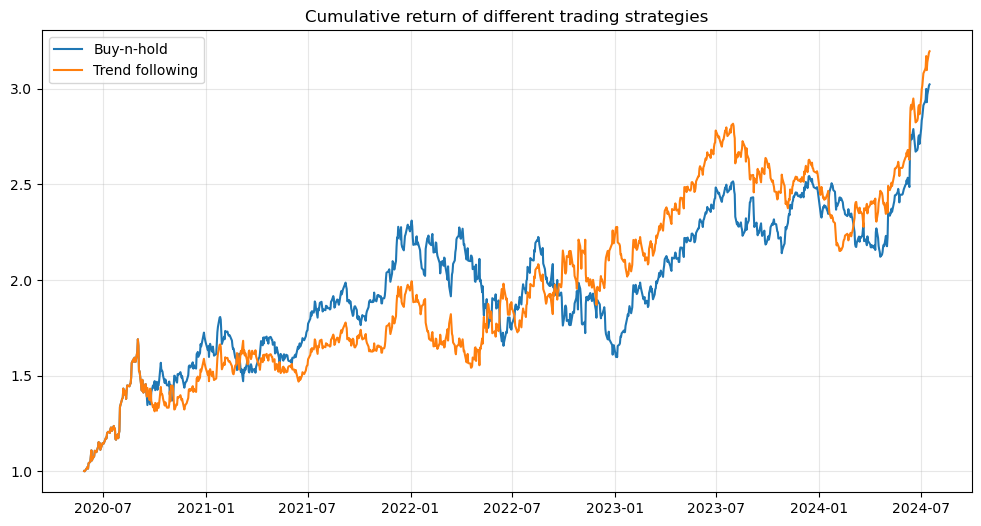

In [60]:
# Visualizing results of both strategies:
plt.plot(np.exp(apple_trade['log_return_bnh']).cumprod(), label = 'Buy-n-hold')
plt.plot(np.exp(apple_trade['log_return_tfs']).cumprod(), label = 'Trend following')
plt.legend(loc=2)
plt.title('Cumulative return of different trading strategies')
plt.grid(True, alpha=.3)

In [61]:
# Compare returns of both strategies
#bnh
print(np.exp(apple_trade['log_return_bnh']).cumprod()[-1] - 1)
#tfs
print(np.exp(apple_trade['log_return_tfs']).cumprod()[-1] - 1)

2.0233909023603
2.1966363630048673


## Ignore

In [9]:
apple = download_stock_history('AAPL', start='2020-01-01', end=today_date)
nvda = download_stock_history('NVDA', start='2020-01-01', end=today_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


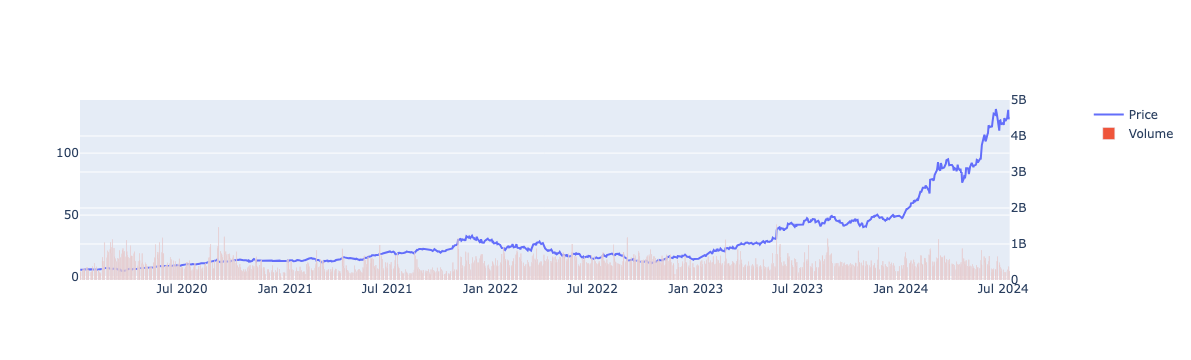

In [11]:
nvda_fig = make_subplots(specs=[[{'secondary_y':True}]])
nvda_fig.add_trace(go.Scatter(x=nvda.index, y=nvda['Close'], name='Price'), secondary_y=False)
nvda_fig.add_trace(go.Bar(x=nvda.index, y=nvda['Volume'], name = 'Volume'), secondary_y=True)
#rescale volume
nvda_fig.update_yaxes(range=[0,5000000000], secondary_y=True)
nvda_fig.update_yaxes(visible=True, secondary_y=True)
nvda_fig

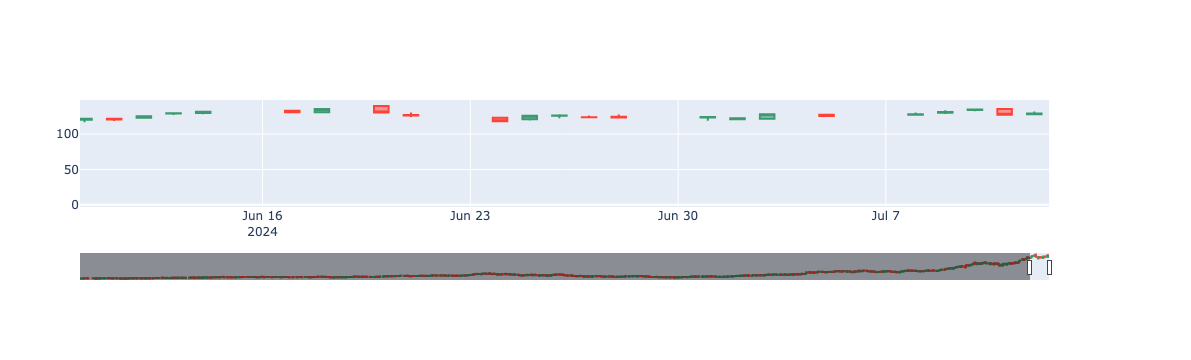

In [12]:
#candlestick
nvda_fig2 = make_subplots(specs=[[{'secondary_y':True}]])
nvda_fig2.add_trace(go.Candlestick(x=nvda.index,
                                   open=nvda['Open'],
                                   high=nvda['High'], 
                                   low=nvda['Low'],
                                   close=nvda['Close'],))

In [72]:
sp500 = yf.download('^GSPC', start = '1990-01-01', end=today_date)

[*********************100%%**********************]  1 of 1 completed


In [73]:
# set up leading close column and target column
sp500['Tomorrow'] = sp500['Close'].shift(-1)
sp500['Target'] = (sp500['Tomorrow'] > sp500['Close']).astype(int)

In [74]:
sp500.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
1990-01-02  353.399994  359.690002  351.980011  359.690002  359.690002   
1990-01-03  359.690002  360.589996  357.890015  358.760010  358.760010   
1990-01-04  358.760010  358.760010  352.890015  355.670013  355.670013   
1990-01-05  355.670013  355.670013  351.350006  352.200012  352.200012   
1990-01-08  352.200012  354.239990  350.540009  353.790009  353.790009   

               Volume    Tomorrow  Target  
Date                                       
1990-01-02  162070000  358.760010       0  
1990-01-03  192330000  355.670013       0  
1990-01-04  177000000  352.200012       0  
1990-01-05  158530000  353.790009       1  
1990-01-08  140110000  349.619995       0

In [75]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

In [76]:
horizons = [5, 10, 15, 30, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    rolling_column = f"SMA_{horizon}"
    sp500[rolling_column] = rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, rolling_column, trend_column]
    
    
sp500['EMA_12'] = sp500['Close'].ewm(12).mean().shift()
sp500['EMA_26'] = sp500['Close'].ewm(26).mean().shift()
EMA_12 = pd.Series(sp500['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(sp500['Close'].ewm(span=26, min_periods=26).mean())
sp500['MACD'] = pd.Series(EMA_12 - EMA_26)
sp500['MACD_signal'] = pd.Series(sp500.MACD.ewm(span=9, min_periods=9).mean())

sp500['RSI'] = relative_strength_idx(sp500)

#sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])


In [78]:
sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

Open         High          Low        Close    Adj Close  \
Date                                                                          
1993-12-14   465.730011   466.119995   462.459991   463.059998   463.059998   
1993-12-15   463.059998   463.690002   461.839996   461.839996   461.839996   
1993-12-16   461.859985   463.980011   461.859985   463.339996   463.339996   
1993-12-17   463.339996   466.380005   463.339996   466.380005   466.380005   
1993-12-20   466.380005   466.899994   465.529999   465.850006   465.850006   
...                 ...          ...          ...          ...          ...   
2024-07-08  5572.750000  5583.109863  5562.509766  5572.850098  5572.850098   
2024-07-09  5584.240234  5590.750000  5574.569824  5576.979980  5576.979980   
2024-07-10  5591.259766  5635.390137  5586.439941  5633.910156  5633.910156   
2024-07-11  5635.209961  5642.450195  5576.529785  5584.540039  5584.540039   
2024-07-12  5590.759766  5655.560059  5590.439941  5615.350098  5615.350098   

                Volume     Tomorrow  Target   ratio_5        SMA_5  ...  \
Date                                                                ...   
1993-12-14   275050000   461.839996       0  0.996617   464.632001  ...   
1993-12-15   331770000   463.339996       1  0.995899   463.741998  ...   
1993-12-16   284620000   466.380005       1  0.999495   463.573999  ...   
1993-12-17   363750000   465.850006       0  1.004991   464.064001  ...   
1993-12-20   255900000   465.299988       0  1.003784   464.094000  ...   
...                ...          ...     ...       ...          ...  ...   
2024-07-08  3185670000  5576.979980       1  1.007342  5532.231934  ...   
2024-07-09  3232920000  5633.910156       1  1.004389  5552.609961  ...   
2024-07-10  3336100000  5584.540039       0  1.010098  5577.590039  ...   
2024-07-11  4020950000  5615.350098       1  0.999543  5587.094043  ...   
2024-07-12  3700280000          NaN       0  1.003328  5596.726074  ...   

                SMA_250  Trend_250  ratio_1000     SMA_1000  Trend_1000  \
Date                                                                      
1993-12-14   450.426959      127.0    1.176082   393.731090       512.0   
1993-12-15   450.509199      126.0    1.172676   393.834170       512.0   
1993-12-16   450.599759      127.0    1.176163   393.941840       513.0   
1993-12-17   450.704039      128.0    1.183537   394.056020       514.0   
1993-12-20   450.811319      128.0    1.181856   394.168080       513.0   
...                 ...        ...         ...          ...         ...   
2024-07-08  4811.091961      143.0    1.312001  4247.596582       531.0   
2024-07-09  4815.642842      143.0    1.312244  4249.957992       532.0   
2024-07-10  4820.289842      143.0    1.324888  4252.367172       532.0   
2024-07-11  4824.587842      142.0    1.312558  4254.699872       531.0   
2024-07-12  4829.027563      143.0    1.319068  4257.057922       531.0   

                 EMA_12       EMA_26       MACD  MACD_signal        RSI  
Date                                                                     
1993-12-14   463.890005   462.621822   0.437440     0.373367  56.544144  
1993-12-15   463.826158   462.638051   0.213977     0.341489  48.311730  
1993-12-16   463.673376   462.608493   0.156119     0.304415  50.864191  
1993-12-17   463.647732   462.635586   0.351517     0.313835  62.389378  
1993-12-20   463.857907   462.774268   0.458322     0.342733  60.972930  
...                 ...          ...        ...          ...        ...  
2024-07-08  5429.244876  5333.097318  63.609584    59.714019  76.716514  
2024-07-09  5440.291432  5341.977050  65.059193    60.783054  72.867573  
2024-07-10  5450.805935  5350.680863  69.994950    62.625433  77.202086  
2024-07-11  5464.890875  5361.170836  69.125976    63.925542  68.228098  
2024-07-12  5474.094657  5369.443770  70.115178    65.163469  72.994623  

[7698 rows x 34 columns]

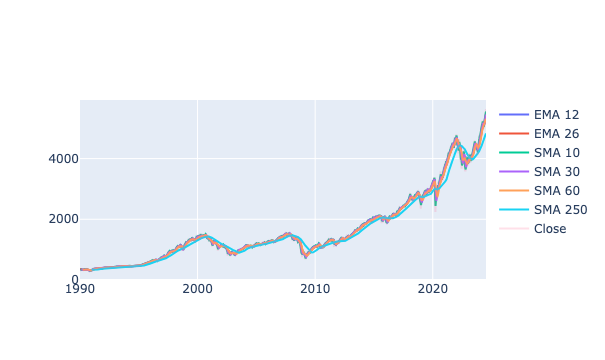

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sp500.index, y=sp500.EMA_12, name='EMA 12'))
fig.add_trace(go.Scatter(x=sp500.index, y=sp500.EMA_26, name='EMA 26'))
fig.add_trace(go.Scatter(x=sp500.index, y=sp500.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=sp500.index, y=sp500.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=sp500.index, y=sp500.SMA_60, name='SMA 60'))
fig.add_trace(go.Scatter(x=sp500.index, y=sp500.SMA_250, name='SMA 250'))
fig.add_trace(go.Scatter(x=sp500.index, y=sp500.Close, name='Close', opacity=0.2))
fig.show()

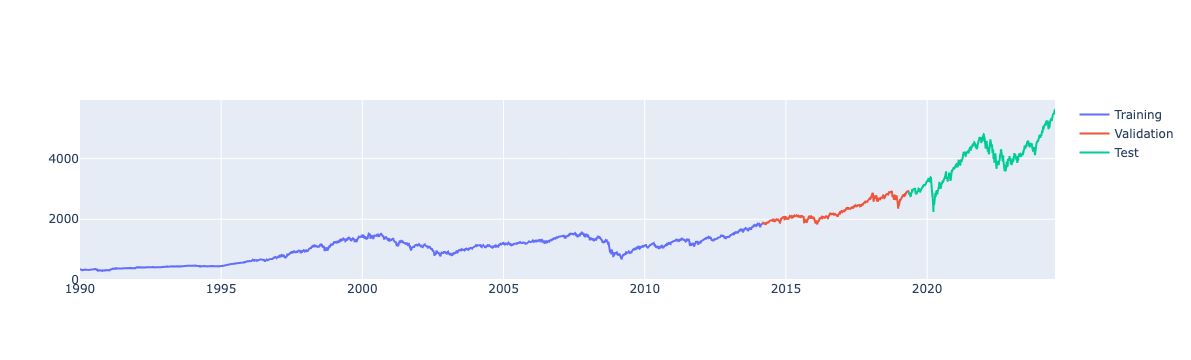

In [81]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(sp500.shape[0] * (1-test_size))
valid_split_idx = int(sp500.shape[0] * (1-(valid_size+test_size)))

train_df  = sp500.iloc[:valid_split_idx]
valid_df  = sp500.iloc[valid_split_idx+1:test_split_idx]
test_df   = sp500.iloc[test_split_idx+1:]

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.index, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.index, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.index,  y=test_df.Close,  name='Test'))
fig.show()